In [1]:
import numpy as np
import cv2

def gaussian(t,sig):
	return (1/np.sqrt(2*np.pi*sig))*np.exp(-t**2/(2*sig**2))

def flowNeighbour(angle):
    angles = np.array([0, 45, 90, 135, 180, 225, 270, 315])
    pairs = [(0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1), (1, 0), (1, 1)]

    angle_diff = np.abs(angles - angle[:, :, np.newaxis])
    ind = np.argmin(angle_diff, axis=-1)

    return np.array(pairs)[ind]

def vectorAngle(x, y):
    zero_mask = x == 0
    res = np.arctan(np.abs(y) / np.abs(x))
    
    res = np.where(zero_mask, np.pi / 2, res)
    res = np.where((x >= 0) & (y >= 0), 2 * np.pi - res, res)
    res = np.where((x >= 0) & (y < 0), res, res)
    res = np.where((x < 0) & (y >= 0), np.pi + res, res)
    res = np.where((x < 0) & (y < 0), np.pi - res, res)
    
    return res

def laplacian(t,sigc,p):
	sigs = 1.05 * sigc
	return gaussian(t,sigc) - p*gaussian(t,sigs)


In [5]:
import cv2
import numpy as np
from numpy import linalg as LA
import pylab as plt
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
from numpy.linalg import norm

def ETF(gray_image, iterations, mu):
    Gx, Gy = sobel(gray_image / 255.0, axis=0), sobel(gray_image / 255.0, axis=1)
    G_magnitude = norm(np.stack([Gx, Gy], axis=2), axis=2)
    G_magnitude /= np.max(G_magnitude)

    tangents = np.stack([-Gy, Gx], axis=2)
    tangents /= np.maximum(norm(tangents, axis=2, keepdims=True), 1e-5)
    size = tangents.shape

    for _ in range(iterations):
        tangents_horizontal = np.zeros(size)

        for w in range(size[1]):
            j_range = np.arange(max(0, w - mu), min(size[1], w + mu + 1))
            wt = ((G_magnitude[:, w, None] - G_magnitude[:, j_range] + 1) * np.sum(tangents[:, w, None] * tangents[:, j_range], axis=2))
            tw = np.sum(wt, axis=1)
            tangents_horizontal[:, w] = np.sum(tangents[:, j_range] * wt[:, :, None], axis=1) / (tw[:, None]+1e-5)

        tangents = np.zeros(size)

        for h in range(size[0]):
            i_range = np.arange(max(0, h - mu), min(size[0], h + mu + 1))
            wt = ((G_magnitude[h, None, :] - G_magnitude[i_range, :]) + 1) * np.sum(tangents_horizontal[h, None, :] * tangents_horizontal[i_range, :], axis=2)
            tw = np.sum(wt, axis=0)
            wt = wt[:, :,None]  # reshape wt to match the dimensions of tangents_horizontal
            # tangents[h, :] = np.sum(tangents_horizontal[i_range, :] * wt, axis=0) / tw[:, None]
            tangents[h, :] = np.sum(tangents_horizontal[i_range, :] * wt, axis=0) / (tw[:, None] + 1e-5)

    return tangents

In [6]:
def FDoG_helper(img, etf, p, sigma_c=0.1, sigma_s=20.0):
    size = img.shape
    H2 = img.copy()
    H1 = np.zeros(size)

    # create an array angles to find all the vector angles of etf
    angles = (vectorAngle(etf[:, :, 0], etf[:, :, 1]) + np.pi / 2) % 2*np.pi

    # finding neighbouring flow pixel
    pix = flowNeighbour(angles * 180 / np.pi)

    h, w = np.indices(size)
    # print(w)

    # print(h.shape, w.shape, pix.shape, angles.shape)

    # pix_reshaped = pix[:,np.newaxis, np.newaxis, :, :]

    # print(pix[:,:,0].shape)
    # print(np.arange(-3, 4).shape)

    # Iterate over the range of values
    for j in range(-3, 4):
        # Calculate the shifted indices
        shifted_h_indices = h + pix[:,:,0] * j
        shifted_w_indices = w + pix[:,:,1] * j

        # Check if the shifted indices are within bounds
        valid_indices = (
            (shifted_h_indices >= 0) &(shifted_h_indices < size[0]) & 
            (shifted_w_indices >= 0) & 
            (shifted_w_indices < size[1])
        )

        # Use the valid indices to update H1 based on your condition
        # weight = gaussian(abs(j), 100.0)
        # H1[valid_indices] += H2[shifted_h_indices[valid_indices], shifted_w_indices[valid_indices]] * weight
        H1[valid_indices] += H2[shifted_h_indices[valid_indices], shifted_w_indices[valid_indices]] * laplacian(abs(j), sigma_c, p)
    
    # total_weight_H1 = np.sum(gaussian(np.arange(-3, 4), 10.0))
    # H1 /= total_weight_H1

    # print("H1 size: ", H1.shape)
    H2 = np.zeros(size)

    for j in range(-3, 4):
        # Calculate the shifted indices
        shifted_h_indices = h + pix[:,:,0] * j
        shifted_w_indices = w + pix[:,:,1] * j

        # Check if the shifted indices are within bounds
        valid_indices = (
            (shifted_h_indices >= 0) & 
            (shifted_h_indices < size[0]) & 
            (shifted_w_indices >= 0) & 
            (shifted_w_indices < size[1])
            )

        # Use the valid indices to update H1 based on your condition
        weight = gaussian(abs(j), sigma_s)
        H2[valid_indices] += H1[shifted_h_indices[valid_indices], shifted_w_indices[valid_indices]] * weight

    # normalize H2  
    total_weight = np.sum(gaussian(np.arange(-3, 4), sigma_s)) # absolute?
    H2 /= total_weight
    return H2

def FDoG(img, etf, p, sigma_c, sigma_s, iter):
    matrix = FDoG_helper(img, etf, p, sigma_c, sigma_s)
    # thresholding
    mask1 = (matrix < 0).astype(int)
    mask2 = ((1 + np.tanh(matrix)) < 0.999).astype(int)

    edges = (1 - mask1 * mask2)*255
    edgeImg = np.minimum(edges, img)

    for i in range(iter-1):
        edges = FDoG_helper(edgeImg, etf, p, sigma_c, sigma_s)
        mask1 = (edges < 0).astype(int)
        mask2 = ((1 + np.tanh(edges)) < 0.999).astype(int)
        edges = (1 - mask1 * mask2)*255
        edgeImg = np.minimum(edges, img)

    return edges, edgeImg, matrix


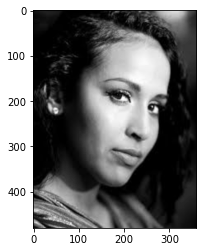

In [10]:
import cv2
import matplotlib.pyplot as plt

# Load an example image (replace 'your_image_path' with the path to your image)
image_path = './image/Extra/imageport.jpg'
gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# resize image
gray_image = cv2.resize(gray_image, (360,480))

# plot resied image
plt.imshow(gray_image, cmap='gray')
plt.show()

# Compute the ETF
etf = ETF(gray_image, iterations=10, mu=7)

In [11]:
# Call the FDoG function
edges, modified_image, H2 = FDoG(gray_image, etf, p=0.977, sigma_c=0.11, sigma_s=100.0, iter=20)

C:\Users\anjal\AppData\Local\Temp\ipykernel_18476\3786633543.py:18: RuntimeWarning: invalid value encountered in divide
  res = np.arctan(np.abs(y) / np.abs(x))


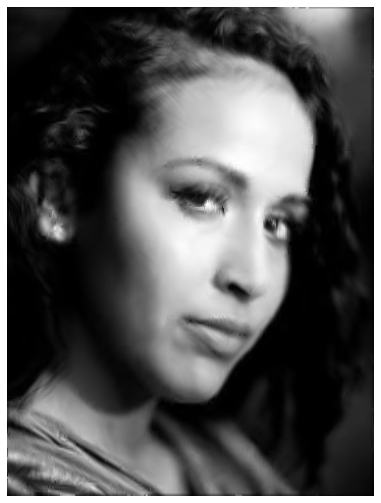

In [13]:
# plot edges
plt.figure(figsize=(24,9))
plt.axis('off')
plt.imshow(H2, cmap='gray')
plt.show()

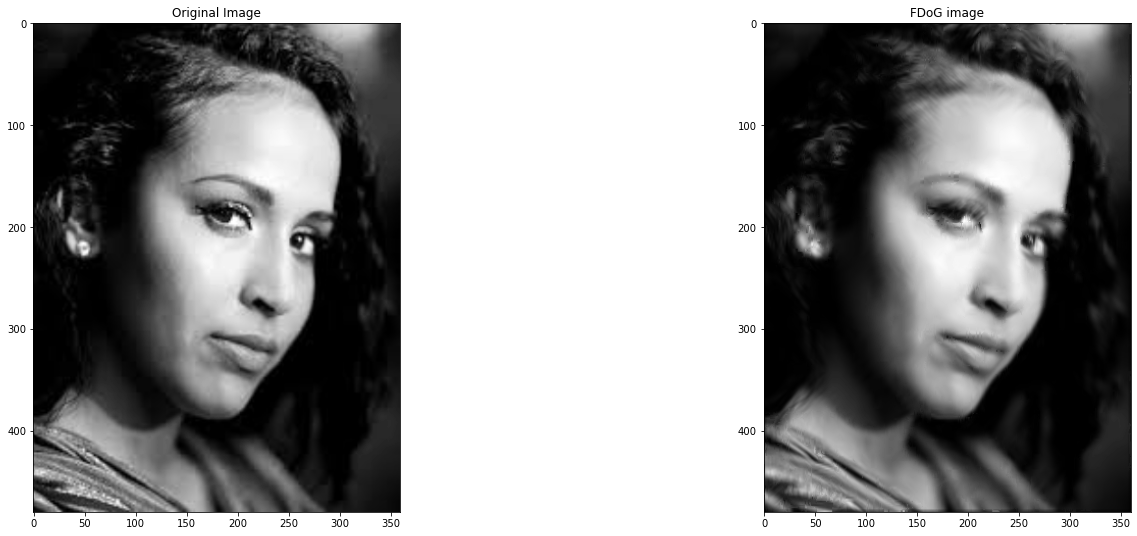

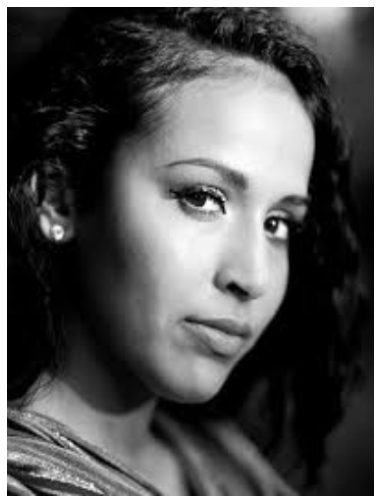

In [14]:


# Visualize the results
plt.figure(figsize=(24, 9))
plt.subplot(121)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')

# make H2 map to 0 to 255
H2_norm = H2.copy()
H2_norm -= np.min(H2_norm)
H2_norm /= np.max(H2_norm)
H2_norm *= 255
H2_norm = H2_norm.astype(np.uint8)

plt.subplot(122)
plt.imshow(H2, cmap='gray')
plt.title('FDoG image')
plt.show()

# plot H2
plt.figure(figsize=(24, 9))
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
plt.show()

# save H2 image
# cv2.imwrite('./image/fdog/car2_H2.png', H2_norm)

# K-Means Quantization Image Abstraction

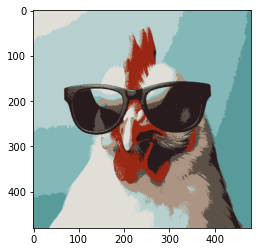

In [15]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

def quantize_image(image_path, k):
    # Read the image
    img = cv2.imread(image_path)
    
    # resize image
    img = cv2.resize(img, (480,480))

    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape the image to be a list of pixels
    pixels = img_rgb.reshape((-1, 3))

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)

    # Get the labels and centers of clusters
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Replace each pixel with the corresponding cluster center
    quantized_pixels = centers[labels].astype(np.uint8)

    # Reshape back to the original image shape
    quantized_img = quantized_pixels.reshape(img_rgb.shape)

    # plot quantized image
    plt.imshow(quantized_img)
    plt.show()
    
    # return quantized_img
    # Save the quantized image
    cv2.imwrite(f'quantized_image_k{k}.png', cv2.cvtColor(quantized_img, cv2.COLOR_RGB2BGR))

# Example usage
image_path = './image/hen.jpg'
k = 8  # Number of clusters (desired colors)
quantize_image(image_path, k)


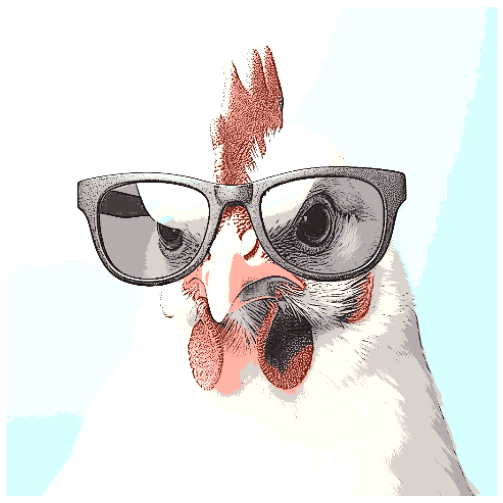

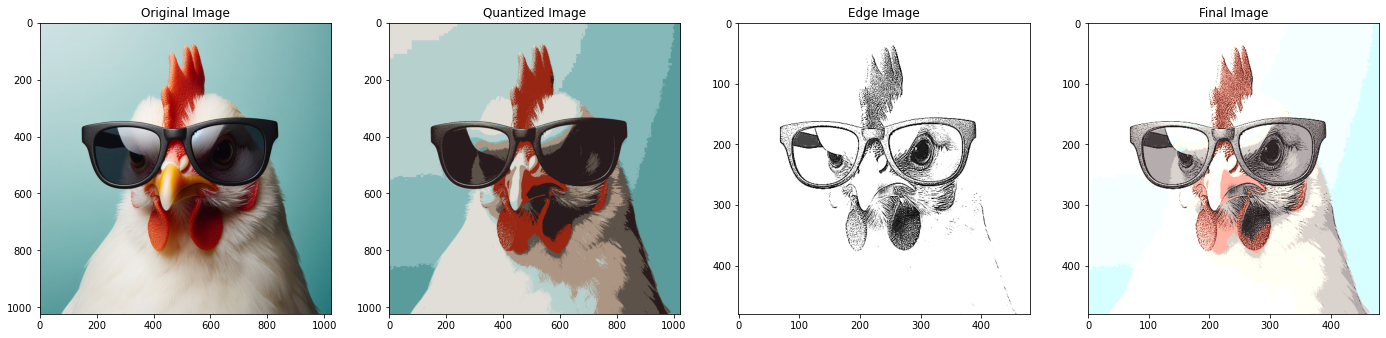

In [16]:
# use quantized image and edge image to get final image
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an example image (replace 'your_image_path' with the path to your image)
image_path = './image/quantization/quantized_image_k8.png'
# load it in color
img = cv2.imread(image_path, cv2.IMREAD_COLOR)
# convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# resize image
img = cv2.resize(img, (480,480))

# load edge image
edges = cv2.imread('./image/quantization/edges.png', cv2.IMREAD_COLOR)

# resize image
edges = cv2.resize(edges, (480,480))

# blend images
img = cv2.addWeighted(img, 0.7, edges, 0.6, 0)


# load hen image
img1 = cv2.imread('./image/hen.jpg')
# convert to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# load quantized image
img2 = cv2.imread('./image/quantization/quantized_image_k8.png')
# convert to RGB
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)


# plot resied image
plt.figure(figsize=(24, 9))
plt.imshow(img)
# dont show axis
plt.axis('off')
plt.show()

# plot all the images
plt.figure(figsize=(24, 9))
plt.subplot(141)
plt.imshow(img1)
plt.title('Original Image')

plt.subplot(142)
plt.imshow(img2, cmap='gray')
plt.title('Quantized Image')

plt.subplot(143)
plt.imshow(edges, cmap='gray')
plt.title('Edge Image')
# plt.show()

plt.subplot(144)
plt.imshow(img)
plt.title('Final Image')
plt.show()